Reinforcement learning avec réseaux de neuronnes 

Paramètres

In [ ]:
total_episodes = 1         # Total episodes
# learning_rate = 0.5           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 0.8                 # Exploration rate # au début explore 

# max_epsilon = 0.99             # Exploration probability at start # 5% d'exploration
min_epsilon = 0.2            # Minimum exploration probabilit
# decay_rate = 0.005             # Exponential decay rate for exploration prob 
decay_rate = 0.00000015

load_weight = True
save_weight = False  

load_path = "/content/drive/MyDrive/frozen_lake_weight/1x16_normal/"
save_path = "/content/drive/MyDrive/frozen_lake_weight/test/"

slippery = False

### Import des librairies 

Utile pour l'environnement

In [ ]:
import numpy as np
import gym
import tensorflow as tf
import random

Utile pour l'affichage graphique 

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym[classic_control]

import gym
import numpy as np

import matplotlib.pyplot as plt

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Création de l'environnement

- le FrozenLake-V0 est depreceated pour la version de gym utilisé
- l'option "is_slippery" autorise le déplacement diagonal
- l'option "map_name" permet de choisir entre deux version "4x4" ou "8x8" 

In [ ]:
# env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
# env = gym.make("FrozenLake-v1", render_mode = "ansi", is_slippery=False)
env = gym.make("FrozenLake-v1", is_slippery=slippery)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


On veut connaitre nb_etats et nb_actions, qui seront respectivement le nombre d'input du réseau de neuronne et le nombre d'output du réseau de neuronne 

In [ ]:
nb_actions = env.action_space.n
nb_etats = env.observation_space.n

### Création du réseau de neuronne 

Caractéristiques du réseau de neuronne :
- tf_input_size : nombre d'entrée dans la couche input du réseau 
- tf_hidden_size : nombre de neuronne dans la couche hidden du réseau
- tf_output_size : nombre de neuronne dans la couhe sortie du réseau 


In [ ]:
tf_input_size = nb_etats
tf_output_size = nb_actions
tf_hidden_size = (tf_input_size+tf_output_size)//2
# tf_hidden_size = int(2/3*tf_input_size+tf_output_size)

In [ ]:
tf.compat.v1.reset_default_graph() # pour supprimer les variables tensorflow d'avant
tf.compat.v1.disable_eager_execution() # nécessaire pour utiliser compat.v1

In [ ]:
# Placeholder du réseau
tf_inputs = tf.compat.v1.placeholder(tf.float32, [None, tf_input_size]) # (1x16)
tf_next_q = tf.compat.v1.placeholder(tf.float32, [None, tf_output_size]) # (1x4)

weight_initer = tf.compat.v1.truncated_normal_initializer(mean=1., stddev=0.1)
biases_initer = tf.compat.v1.truncated_normal_initializer(mean=1., stddev=0.1)


# Hidden Layers (16x10) (10)
# tf.compat.v1.zeros_initializer
tf_weights_1 = tf.compat.v1.get_variable("tf_weights_1", [tf_input_size, tf_hidden_size], initializer = weight_initer)
tf_biases_1 = tf.compat.v1.get_variable("tf_biases_1", [tf_hidden_size], initializer=biases_initer)
tf_outputs_1 = tf.nn.relu(tf.matmul(tf_inputs, tf_weights_1) + tf_biases_1)
# tf_outputs_1 = tf.matmul(tf_inputs, tf_weights_1) + tf_biases_1

# Output (10x4) (4)
tf_weights_out = tf.compat.v1.get_variable("tf_weights_out", [tf_hidden_size, tf_output_size], initializer=weight_initer)
tf_biases_out = tf.compat.v1.get_variable("tf_biases_out", [tf_output_size], initializer=biases_initer)
tf_outputs = tf.matmul(tf_outputs_1, tf_weights_out) + tf_biases_out
# tf_outputs = tf.sigmoid(tf.matmul(tf_outputs_1, tf_weights_out) + tf_biases_out)

# Fonctions
tf_action = tf.argmax(input=tf_outputs, axis=1)
tf_loss = tf.reduce_sum(input_tensor=tf.square(tf_outputs - tf_next_q))
# tf_optimize = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001).minimize(tf_loss)
tf_optimize = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01).minimize(tf_loss)

Pour faire fonctionner le réseau, on peut utiliser les sessions de tensorflow. <br>
Les fonctions utilisables sont :
- tf_outputs : (feed : tf_inputs) 
- tf_action : (feed : tf_inputs) pour obtenir le meilleur tf_action possible
- tf_loss : (feed : tf_inputs, tf_next_q) pour calculer la différence entre les outputs calculés par le réseau et les outputs idéals (donnée par le q_learning)
- tf_optimize : (feed : tf_outputs, tf_next_q) appel le tf_loss pour changer les poids afin de minimaliser le loss 

Poids à l'initialisation

In [ ]:
sess = tf.compat.v1.InteractiveSession()
initializer = tf.compat.v1.global_variables_initializer()
sess.run(initializer)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
import sys 
print("tf_weights_1", tf_weights_1)
sess.run(tf.print(tf_weights_1, output_stream=sys.stderr))
print("\n")
print("tf_biases_1", tf_biases_1)
sess.run(tf.print(tf_biases_1, output_stream=sys.stderr))
print("\n")
print("tf_weights_out", tf_weights_out)
sess.run(tf.print(tf_weights_out, output_stream=sys.stderr))
print("\n")
print("tf_biases_out", tf_biases_out)
sess.run(tf.print(tf_biases_out, output_stream=sys.stderr))
print("\n")


tf_weights_1 <tf.Variable 'tf_weights_1:0' shape=(16, 10) dtype=float32>
[[0.936707854 0.893586576 0.934652388 ... 1.05151069 0.946948051 1.00739944]
 [1.02476203 0.848303795 1.04644394 ... 1.19049835 0.96657759 0.970404804]
 [1.01188087 1.05139744 1.0294019 ... 0.954786301 0.87413013 0.920786917]
 ...
 [1.0314939 0.857428074 1.01055932 ... 1.00077379 0.857493639 1.11754704]
 [1.04422152 1.03599226 0.913097918 ... 0.961825252 1.13519657 0.883755505]
 [0.998389721 0.857583821 1.15990412 ... 1.05492294 1.12618136 0.897175252]]


tf_biases_1 <tf.Variable 'tf_biases_1:0' shape=(10,) dtype=float32>
[1.1020484 1.09784806 1.1312145 ... 1.18087196 0.834360361 0.936000109]


tf_weights_out <tf.Variable 'tf_weights_out:0' shape=(10, 4) dtype=float32>
[[0.924541771 0.89595741 0.987987459 0.985623777]
 [0.961854458 1.15398085 1.05579185 1.05462456]
 [0.899097 0.945765495 1.08002281 1.04452252]
 ...
 [1.00287306 1.08987832 1.00911021 1.1134901]
 [0.993415713 0.949341178 1.04271865 0.896123171]
 [0.

In [ ]:
for i in range(16):
  print("Etat : {}, {}".format(i,sess.run([tf_outputs], feed_dict={tf_inputs: np.identity(16)[i:i+1]})[0][0]))

Etat : 0, [20.764101 20.816854 21.324043 20.968819]
Etat : 1, [20.995186 21.011179 21.594334 21.230448]
Etat : 2, [20.768085 20.773481 21.419285 20.99112 ]
Etat : 3, [21.03892  21.015186 21.628557 21.245768]
Etat : 4, [20.78756  20.817322 21.390364 21.005333]
Etat : 5, [21.161959 21.203999 21.791176 21.357439]
Etat : 6, [21.522108 21.479776 22.134275 21.721094]
Etat : 7, [20.513144 20.568413 21.097052 20.740566]
Etat : 8, [20.724087 20.789377 21.345774 20.922974]
Etat : 9, [20.87342  20.88853  21.494995 21.081459]
Etat : 10, [21.092129 21.128988 21.72089  21.327557]
Etat : 11, [20.817554 20.863312 21.458704 21.024761]
Etat : 12, [20.783802 20.818121 21.343092 20.968634]
Etat : 13, [20.885656 20.887318 21.467278 21.105087]
Etat : 14, [20.835102 20.807068 21.464779 21.028057]
Etat : 15, [21.17122  21.17327  21.827194 21.369728]


### Entrainement du réseau

[1.0, 0.999999880000009, 0.999999640000081, 0.9999992800003241, 0.9999988000009001, 0.9999982000020251, 0.9999974800039693, 0.9999966400070563, 0.9999956800116643, 0.9999946000182254, 0.9999934000272255, 0.9999920800392046, 0.9999906400547565, 0.9999890800745295, 0.9999874000992253, 0.9999856001296001, 0.9999836801664639, 0.9999816402106805, 0.9999794802631679, 0.9999772003248981, 0.9999748003968971, 0.9999722804802447, 0.999969640576075, 0.9999668806855759, 0.9999640008099893, 0.999961000950611, 0.999957881108791, 0.9999546412859333, 0.9999512814834954, 0.9999478017029895, 0.9999442019459812, 0.9999404822140905, 0.9999366425089913, 0.9999326828324111, 0.9999286031861319, 0.9999244035719892, 0.9999200839918729, 0.9999156444477266, 0.999911084941548, 0.9999064054753886, 0.9999016060513541, 0.9998966866716041, 0.9998916473383521, 0.9998864880538656, 0.999881208820466, 0.9998758096405287, 0.9998702905164831, 0.9998646514508127, 0.9998588924460547, 0.9998530135048005, 0.9998470146296949, 0

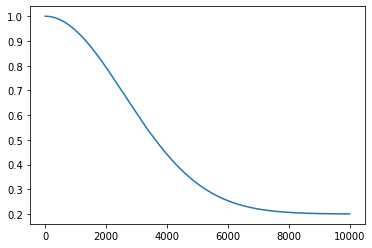

In [ ]:
X = []
eps = 1
# rate = 0.00002
rate = 0.00000015
mini = 0.2
for i in range(10000):
  eps = mini + (eps - mini)*np.exp(-rate*i)
  X.append(eps)
print(X)
import matplotlib.pyplot as plt
plt.plot(X)


Sauvegarde des poids 

In [ ]:
saver = tf.compat.v1.train.Saver()
if load_weight:
    saver.restore(sess, load_path)
    print("Model restored.")    

Model restored.


In [ ]:
rewards = []

for episode in range(total_episodes):
    state = env.reset()
    done = False
    total_rewards = 0
    old_state = -10
    # on fait commencer aléatoirement sur la map
    # state = random.randint(0,15)
    ## print("episode {} commence le jeu au state {} ".format(episode, state))
    ## reward = 0
    for step in range(max_steps):
        reward = 0
        # choix de l'action
        # politique espilon-greedy
        exploration = random.uniform(0,1)
        if exploration > epsilon:
            action = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
        else:
            action = env.action_space.sample()
            if state in [2,3]:
              action = random.choice([0,1,2])
            if state in [7,11]:
              action = random.choice([0,1,3])
            if state in [13,14]:
              action = random.choice([0,2,3])
            if state in [4,8]:
              action = random.choice([1,2,3])
            if state == 0:
              action = random.choice([1,2])
            if state == 3:
              action = random.choice([0,1])
            if state == 12:
              action = random.choice([2,3])
            if state == 15:
              action = random.choice([0,3])
            ## print("explore")
        
        

        # on avance   
        # new_state, reward, done, info = env.step(action)
        new_state, _, done, info = env.step(action)
        
        # print("old_state {},new_state {}, action {}".format(state,new_state,action))
        if new_state in [5,7,11,12]:
            reward -= 10000
        """
        if new_state in [5,7,11,12]:
            print("done?",done,"new_state",new_state)
        """

        """
        if new_state == 15:
            reward += 100
        if old_state == new_state :
            reward -= 100
        """
        if new_state == state:
            reward -= 1000
        if old_state == new_state :
            reward -= 1000
        if new_state == 15:
            reward += 10000

        # rewarding and updating
        q_vector = sess.run([tf_outputs], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
        # print("state {} / q_vector {} / action {}".format(state,q_vector,action))
        # q_target = reward + gamma * np.max(q_vector) # correspond en principe à l'action choisie
        q_target = reward + np.max(q_vector)
        q_vector[action] = q_target 
        # print("q_vector {} / q_target {}".format(q_vector,q_target))
        _, loss = sess.run([tf_optimize, tf_loss],
                          feed_dict={tf_inputs: np.identity(16)[state:state+1], 
                                      tf_next_q:q_vector.reshape(1,4)})
        
        old_state = state
        state = new_state
        total_rewards += reward 
        if (step > 97):
            print("Episode {} finished after {} timesteps, last state : {} and total_rewards {}".format(episode, step+1,state,total_rewards))
            epsilon = min_epsilon + (epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            break
        if done == True:
            print("Episode {} finished after {} timesteps, last state : {} and total_rewards {}".format(episode, step+1,state,total_rewards))
            epsilon = min_epsilon + (epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            break
    rewards.append(total_rewards)
    # print(total_rewards)
    print("episode {} finished".format(episode))
# print ("Score over time: " +  str(sum(rewards)/total_episodes))

Episode 0 finished after 10 timesteps, last state : 5 and total_rewards -15000
episode 0 finished


In [ ]:
saver = tf.compat.v1.train.Saver()
if save_weight:
    saved_path = saver.save(sess, save_path)
    print("Model saved in file: %s" % saved_path)

In [ ]:
for i in range(16):
  print("Etat : {}, {}".format(i,sess.run([tf_outputs], feed_dict={tf_inputs: np.identity(16)[i:i+1]})[0][0]))

Etat : 0, [-267662.25 -267067.6  -267347.97 -267488.7 ]
Etat : 1, [-242877.33 -243442.11 -241955.5  -242842.83]
Etat : 2, [-236258.8  -235669.05 -236046.31 -236115.97]
Etat : 3, [-240447.77 -240727.08 -239712.45 -240382.12]
Etat : 4, [-275636.3  -275036.06 -275319.   -275450.34]
Etat : 5, [-162830.   -163032.27 -162295.98 -162781.89]
Etat : 6, [-260952.64 -260511.89 -260548.05 -260763.56]
Etat : 7, [-162827.36 -163028.55 -162294.27 -162778.8 ]
Etat : 8, [-251799.47 -252161.5  -250913.48 -251679.7 ]
Etat : 9, [-234546.56 -233995.89 -234187.05 -234307.08]
Etat : 10, [-252399.61 -251833.39 -252049.86 -252175.27]
Etat : 11, [-162809.7  -163014.62 -162274.52 -162761.45]
Etat : 12, [-162822.89 -163020.4  -162289.14 -162772.27]
Etat : 13, [-215595.67 -215301.05 -215187.55 -215433.89]
Etat : 14, [-39451.383 -40333.473 -38907.414 -39624.23 ]
Etat : 15, [-162824.58 -163024.19 -162291.58 -162776.02]


In [ ]:
tab = np.zeros((4,4))

tab[0][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[0:0+1]})[0][0]
tab[0][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[1:1+1]})[0][0]
tab[0][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[2:2+1]})[0][0]
tab[0][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[3:3+1]})[0][0]

tab[1][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[4:4+1]})[0][0]
tab[1][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[5:5+1]})[0][0]
tab[1][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[6:6+1]})[0][0]
tab[1][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[7:7+1]})[0][0]

tab[2][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[8:8+1]})[0][0]
tab[2][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[9:9+1]})[0][0]
tab[2][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[10:10+1]})[0][0]
tab[2][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[11:11+1]})[0][0]

tab[3][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[12:12+1]})[0][0]
tab[3][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[13:13+1]})[0][0]
tab[3][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[14:14+1]})[0][0]
tab[3][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[15:15+1]})[0][0]

print(tab)
print("0: LEFT, 1: DOWN, 2: RIGHT, 3: UP")

[[1. 2. 1. 2.]
 [1. 2. 1. 2.]
 [2. 1. 1. 2.]
 [2. 2. 2. 2.]]
0: LEFT, 1: DOWN, 2: RIGHT, 3: UP


Poids après entrainement et utilisé pendant la phase de test

In [ ]:
print("tf_weights_1", tf_weights_1)
sess.run(tf.print(tf_weights_1, output_stream=sys.stderr))
print("\n")
print("tf_biases_1", tf_biases_1)
sess.run(tf.print(tf_biases_1, output_stream=sys.stderr))
print("\n")
print("tf_weights_out", tf_weights_out)
sess.run(tf.print(tf_weights_out, output_stream=sys.stderr))
print("\n")
print("tf_biases_out", tf_biases_out)
sess.run(tf.print(tf_biases_out, output_stream=sys.stderr))
print("\n")


tf_weights_1 <tf.Variable 'tf_weights_1:0' shape=(16, 10) dtype=float32>
[[91.6326447 111.856529 89.2941437 ... 88.0382614 99.73349 84.8353195]
 [74.5858 85.588768 72.1086807 ... 70.1199493 77.5430679 69.2479477]
 [64.7153549 78.5013809 62.8619385 ... 58.9638557 71.7268524 58.2373886]
 ...
 [47.1868782 48.8065681 46.8265038 ... 46.0225792 49.7096672 44.5180664]
 [-107.863129 -112.277534 -107.943527 ... -104.47274 -111.026123 -104.616272]
 [1.00462747 1.12805259 1.00318253 ... 0.95589304 0.901234269 0.968594611]]


tf_biases_1 <tf.Variable 'tf_biases_1:0' shape=(10,) dtype=float32>
[145.589859 168.831161 141.29274 ... 136.78009 153.039062 136.381012]


tf_weights_out <tf.Variable 'tf_weights_out:0' shape=(10, 4) dtype=float32>
[[-116.186066 -118.492226 -115.044449 -117.753128]
 [-126.097366 -129.888031 -126.323036 -129.222794]
 [-114.174088 -116.97361 -114.555809 -113.759865]
 ...
 [-113.746452 -113.77742 -106.062981 -110.674835]
 [-117.499832 -120.154625 -120.383064 -120.612328]
 [-113



```
# Ce texte est au format code
```

Affichage graphiqu

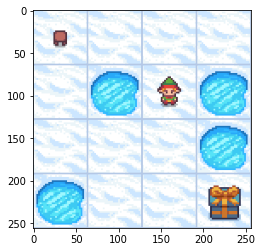

Episode/Step 33 3
State/Next_action 6 1


In [ ]:
import time 


env = gym.make("FrozenLake-v1",is_slippery=slippery)
state = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for episode in range(100):
  env.reset()
  for i in range(50):
    action = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
    print("Episode/Step {} {}".format(episode,i))
    print("State/Next_action {} {}".format(state,action))
    time.sleep(1)
    new_state, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    state = new_state
    if done:
      break
ipythondisplay.clear_output(wait=True)
env.close()

display.stop()